In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from googlesearch import search
import requests
import time
import re
import folium
from folium import Marker
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from folium.plugins import HeatMapWithTime
import json
import us
import matplotlib.pyplot as plt

#Define my csv file from NIOSH
disaster = 'Mining disasters-fatilities.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(disaster)

# Display the first few rows of the DataFrame
print(data.head())


         Date               Mine Name        City State  Killed Product  \
0  1839-03-17             Black Heath    Richmond    VA      53    Coal   
1  1844-06-14             Black Heath    Richmond    VA      11    Coal   
2  1846-01-11                   No. 1  Carbondale    PA      14    Coal   
3  1847-02-18                 Spencer  Pottsville    PA       7    Coal   
4  1850-11-29  Cox's Pit, Clover Hill  Winterpock    VA       7    Coal   

  Accident Type Mine Type Mining Sector  
0     Explosion        UG          Coal  
1     Explosion        UG          Coal  
2       Cave-in        UG          Coal  
3     Explosion        UG          Coal  
4     Explosion        UG          Coal  


In [2]:
# Replace 'unknown' (case-sensitive) with NaN to treat it as a missing value
data.replace('Unknown', pd.NA, inplace=True)

# Drop rows with any null (NaN) values
cleaned_data = data.dropna()

# Display the cleaned DataFrame
print(cleaned_data.head())


         Date               Mine Name        City State  Killed Product  \
0  1839-03-17             Black Heath    Richmond    VA      53    Coal   
1  1844-06-14             Black Heath    Richmond    VA      11    Coal   
2  1846-01-11                   No. 1  Carbondale    PA      14    Coal   
3  1847-02-18                 Spencer  Pottsville    PA       7    Coal   
4  1850-11-29  Cox's Pit, Clover Hill  Winterpock    VA       7    Coal   

  Accident Type Mine Type Mining Sector  
0     Explosion        UG          Coal  
1     Explosion        UG          Coal  
2       Cave-in        UG          Coal  
3     Explosion        UG          Coal  
4     Explosion        UG          Coal  


In [3]:

# Dictionary to map abbreviations to full state names
state_mapping = {
    'VA': 'Virginia', 'PA': 'Pennsylvania', 'NV': 'Nevada', 'OH': 'Ohio',
    'MI': 'Michigan', 'CA': 'California', 'IN': 'Indiana', 'MT': 'Montana',
    'WY': 'Wyoming', 'IL': 'Illinois', 'CO': 'Colorado', 'NY': 'New York',
    'WV': 'West Virginia', 'OK': 'Oklahoma', 'MO': 'Missouri', 'KS': 'Kansas',
    'AL': 'Alabama', 'WA': 'Washington', 'VT': 'Vermont', 'IA': 'Iowa',
    'KY': 'Kentucky', 'NM': 'New Mexico', 'NC': 'North Carolina', 
    'TN': 'Tennessee', 'AR': 'Arkansas', 'UT': 'Utah', 'MD': 'Maryland',
    'AK': 'Alaska', 'NJ': 'New Jersey', 'MN': 'Minnesota', 'AZ': 'Arizona',
    'ID': 'Idaho', 'LA': 'Louisiana', 'GA': 'Georgia', 'WI': 'Wisconsin'
}

# Replace abbreviations with full names
cleaned_data['State'] = cleaned_data['State'].map(state_mapping)
cleaned_data.head(10)

/var/folders/_t/5r8lrg6j3qndjp652jr5dg200000gn/T/ipykernel_53335/2635151891.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['State'] = cleaned_data['State'].map(state_mapping)


,Date,Mine Name,City,State,Killed,Product,Accident Type,Mine Type,Mining Sector
0,1839-03-17,Black Heath,Richmond,Virginia,53,Coal,Explosion,UG,Coal
1,1844-06-14,Black Heath,Richmond,Virginia,11,Coal,Explosion,UG,Coal
2,1846-01-11,No. 1,Carbondale,Pennsylvania,14,Coal,Cave-in,UG,Coal
3,1847-02-18,Spencer,Pottsville,Pennsylvania,7,Coal,Explosion,UG,Coal
4,1850-11-29,"Cox's Pit, Clover Hill",Winterpock,Virginia,7,Coal,Explosion,UG,Coal
5,1854-05-14,Chesterfield,New Richmond,Virginia,20,Coal,Explosion,UG,Coal
6,1855-03-18,Midlothian,Coalfield,Virginia,55,Coal,Explosion,UG,Coal
7,1859-04-12,Bright Hope,Winterpock,Virginia,9,Coal,Explosion,UG,Coal
8,1863-11-29,"Raccoon, Clover Hill",Winterpock,Virginia,17,Coal,Explosion,UG,Coal
9,1867-04-02,Bright Hope,Winterpock,Virginia,69,Coal,Explosion,UG,Coal


In [21]:
#This code will google mine name and extract top 3 wikipedia link.
def clean_query(text):
    """
    Cleans a query string by removing special characters and extra spaces.
    """
    return re.sub(r"[^\w\s]", "", text).strip()

def get_wikipedia_links_from_html(mine_name, city, state, top_n=3):
    """
    Fetches and parses HTML from Google search for Wikipedia links.
    """
    # Clean and build the query
    mine_name_clean = clean_query(mine_name)
    city_clean = clean_query(city)
    state_clean = clean_query(state)
    query = f"{mine_name_clean} {city_clean} {state_clean}  wikipedia"

    # URL encode the query for Google search
    google_search_url = f"https://www.google.com/search?q={query}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"
    }

    try:
        response = requests.get(google_search_url, headers=headers)
        time.sleep(3)  # Delay between requests to avoid rate-limiting
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all <a> tags with href containing "https://en.wikipedia.org/wiki/"
        links = [
            a["href"]
            for a in soup.find_all("a", href=True)
            if "https://en.wikipedia.org/wiki/" in a["href"]
        ]

        # Deduplicate and return the top N links
        return list(dict.fromkeys(links))[:top_n]

    except requests.exceptions.RequestException as e:
        print(f"Error fetching HTML for query '{query}': {e}")
        return []

# Test on dataset

# Add a new column for Wikipedia links
cleaned_data["Wikipedia Links"] = None  # Initialize with None

for index, row in cleaned_data.iterrows():
    # Fetch links
    links = get_wikipedia_links_from_html(row["Mine Name"], row["City"], row["State"])
    if links:
        cleaned_data.at[index, "Wikipedia Links"] = links
    else:
        cleaned_data.at[index, "Wikipedia Links"] = []
    print(f"Processed row {index + 1}/{len(cleaned_data)}: {row['Mine Name']}")

# Save to a CSV file for inspection
cleaned_data.to_csv("wikipedia_links_test.csv", index=False)
print("Saved results to 'wikipedia_links_test.csv'")



NameError: name 'cleaned_data' is not defined

In [ ]:
#clean data
wiki_links = "wikipedia_links_test.csv"  # Redefine new csv file with wikipedia links
wikipedia_link = pd.read_csv(wiki_links)

# Filter out rows where "Wikipedia Links" contains only an empty list
wiki_cleaned_data = wikipedia_link[~wikipedia_link["Wikipedia Links"].isin(["[]"])]

In [ ]:
#This code will web scrape coordinates in wikepidia 
def extract_coordinates(wikipedia_links):
    """
    Extracts the coordinates (latitude and longitude) from a list of Wikipedia URLs.

    Parameters:
    - wikipedia_links (list): List of Wikipedia URLs.

    Returns:
    - tuple: (latitude, longitude) if found, otherwise (None, None).
    """
    try:
        # Ensure `wikipedia_links` is a list, even if read as a string from the DataFrame
        links_list = eval(wikipedia_links) if isinstance(wikipedia_links, str) else wikipedia_links

        # Iterate through each link in the list
        for url in links_list:
            try:
                # Fetch the HTML content of the page
                response = requests.get(url, timeout=10)
                if response.status_code == 200:
                    html_content = response.text

                    # Parse the HTML with BeautifulSoup
                    soup = BeautifulSoup(html_content, "html.parser")

                    # Locate the script tag containing the JSON with coordinates
                    script_tag = soup.find("script", text=lambda t: t and "wgCoordinates" in t)

                    if script_tag:
                        # Extract the script's content
                        script_content = script_tag.string

                        # Find the JSON-like part in the script content
                        start_index = script_content.find('{"lat":')
                        end_index = script_content.find('}', start_index) + 1  # Include closing curly brace

                        if start_index != -1 and end_index != -1:
                            # Extract the JSON string
                            json_text = script_content[start_index:end_index]

                            # Parse the JSON string
                            coordinates = json.loads(json_text)

                            # Access latitude and longitude
                            latitude = coordinates.get("lat")
                            longitude = coordinates.get("lon")

                            if latitude and longitude:
                                return latitude, longitude
            except Exception as e:
                print(f"Error fetching coordinates from {url}: {e}")

    except Exception as e:
        print(f"Error processing Wikipedia Links: {e}")

    # Return None if no coordinates were found after checking all links
    return None, None


# Apply the function to the dataset
wiki_cleaned_data["Coordinates"] = wiki_cleaned_data["Wikipedia Links"].apply(
    lambda links: extract_coordinates(links) if isinstance(links, str) and links != "[]" else (None, None)
)

# Split the coordinates into separate Latitude and Longitude columns
wiki_cleaned_data["Latitude"] = wiki_cleaned_data["Coordinates"].apply(lambda x: x[0] if x else None)
wiki_cleaned_data["Longitude"] = wiki_cleaned_data["Coordinates"].apply(lambda x: x[1] if x else None)

# Drop the Coordinates column as it is no longer needed
wiki_cleaned_data.drop(columns=["Coordinates"], inplace=True)

# Print the updated DataFrame
print(wiki_cleaned_data[["Wikipedia Links", "Latitude", "Longitude"]])
wiki_cleaned_data.to_csv("wiki_cleaned_data_with_filled_coordinates.csv", index=False)



/var/folders/_t/5r8lrg6j3qndjp652jr5dg200000gn/T/ipykernel_96758/3149454754.py:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find("script", text=lambda t: t and "wgCoordinates" in t)


Error fetching coordinates from https://en.wikipedia.org/wiki/Midlothian,_Virginia: Expecting value: line 1 column 33 (char 32)
Error fetching coordinates from https://en.wikipedia.org/wiki/Midlothian,_Virginia: Expecting value: line 1 column 33 (char 32)
Error fetching coordinates from https://en.wikipedia.org/wiki/Midlothian,_Virginia: Expecting value: line 1 column 33 (char 32)
Error fetching coordinates from https://en.wikipedia.org/wiki/Bluefield,_West_Virginia: Expecting value: line 1 column 32 (char 31)
Error fetching coordinates from https://en.wikipedia.org/wiki/Burton,_West_Virginia: Expecting value: line 1 column 33 (char 32)
                                       Wikipedia Links   Latitude  Longitude
0    ['https://en.wikipedia.org/wiki/Black_Heath', ...  37.519822 -77.632002
1    ['https://en.wikipedia.org/wiki/Black_Heath', ...  37.519822 -77.632002
2    ['https://en.wikipedia.org/wiki/Carbondale_min...        NaN        NaN
3    ['https://en.wikipedia.org/wiki/Coal_Regio

/var/folders/_t/5r8lrg6j3qndjp652jr5dg200000gn/T/ipykernel_96758/3149454754.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_cleaned_data["Coordinates"] = wiki_cleaned_data["Wikipedia Links"].apply(
/var/folders/_t/5r8lrg6j3qndjp652jr5dg200000gn/T/ipykernel_96758/3149454754.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_cleaned_data["Latitude"] = wiki_cleaned_data["Coordinates"].apply(lambda x: x[0] if x else None)
/var/folders/_t/5r8lrg6j3qndjp652jr5dg200000gn/T/ipykernel_96758/31494547

Is is discovered that some of the locations are at outside of US. Code may have not extracted the coordinates in a correct wikipeida link.
Therefore, those coordinates are replaced with new coordiates based on the city and state. 

In [ ]:
cleaned_data_coord=pd.read_csv("wiki_cleaned_data_with_filled_coordinates.csv")

# Initialize the geocoder
geolocator = Nominatim(user_agent="mine_geocoder")

# List of mines with incorrect locations
wrong_mine_names = [
    "William Station No. 9 Mine",
    "Blanche",
    "Bond & Bruce",
    "Richardson",
    "Mama No. 3",
    "Midlothian",
    "No. 5 Mine",
    "Diamond No. 1",
    "No. 3 Mine",
    "Viking Mine",
    "Connellsville",
    "Hill Farm", 
    "Pratt No. 1 Shaft", 
    "West Slope No. 1", 
    "Milby & Dow", 
    "Central Slope 77", 
    "Yolande", 
    "Yolande No. 1", 
    "No. 2", 
    "Stag Canon No. 1", 
    "Rains", 
    "Barnes Hecker", 
    "Connellsville", 
    "Viking Mine", 
    "No. 3 Mine", 
    "No. 5 Mine",
]

# Function to geocode city and state
def geocode_location(city, state):
    try:
        location = geolocator.geocode(f"{city}, {state}")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Replace latitude and longitude for the mines with incorrect locations
for mine_name in wrong_mine_names:
    # Filter the dataframe for the specific mine
    mine_row = cleaned_data_coord[cleaned_data_coord["Mine Name"] == mine_name]
    if not mine_row.empty:
        city = mine_row.iloc[0]["City"]
        state = mine_row.iloc[0]["State"]
        
        # Geocode to find the correct latitude and longitude
        lat, lon = geocode_location(city, state)
        
        if lat is not None and lon is not None:
            # Update the dataframe with the correct latitude and longitude
            cleaned_data_coord.loc[cleaned_data_coord["Mine Name"] == mine_name, "Latitude"] = lat
            cleaned_data_coord.loc[cleaned_data_coord["Mine Name"] == mine_name, "Longitude"] = lon
            print(f"Updated {mine_name}: Latitude = {lat}, Longitude = {lon}")
        else:
            print(f"Failed to geocode {mine_name}: City = {city}, State = {state}")


Updated William Station No. 9 Mine: Latitude = 37.4975469, Longitude = -87.9453
Updated Blanche: Latitude = 47.576303949999996, Longitude = -122.14057084999999
Updated Bond & Bruce: Latitude = 36.935629500000005, Longitude = -82.53298739803341
Updated Richardson: Latitude = 40.7149524, Longitude = -76.3158828
Updated Mama No. 3: Latitude = 35.2503711, Longitude = -94.3185459
Updated Midlothian: Latitude = 38.0045531, Longitude = -81.3503865
Updated No. 5 Mine: Latitude = 33.2556719, Longitude = -87.3208336
Updated Diamond No. 1: Latitude = 37.397545, Longitude = -87.7627898
Updated No. 3 Mine: Latitude = 36.9336934, Longitude = -82.6298965
Updated Viking Mine: Latitude = 39.4667025, Longitude = -87.4139119
Updated Connellsville: Latitude = 33.3067811, Longitude = -87.1913862
Updated Hill Farm: Latitude = 39.977928, Longitude = -79.6143059
Updated Pratt No. 1 Shaft: Latitude = 33.5401055, Longitude = -86.8688808
Updated West Slope No. 1: Latitude = 40.9585104, Longitude = -75.9322065
Up

Seems like some of the coordinates are not extracted. Use openstreetmap nominatim API again to get coordinates

In [ ]:
# Function to fetch coordinates using OpenStreetMap Nominatim API
def fetch_coordinates(city, state):
    """
    Fetches latitude and longitude for a given city and state using OpenStreetMap Nominatim API.

    Parameters:
    - city (str): City name
    - state (str): State name

    Returns:
    - tuple: Latitude and Longitude or (None, None) if not found
    """
    try:
        query = f"{city}, {state}"
        url = "https://nominatim.openstreetmap.org/search"
        params = {"q": query, "format": "json", "limit": 1}
        headers = {"User-Agent": "GeoDataFetcher"}
        response = requests.get(url, params=params, headers=headers, timeout=10)

        if response.status_code == 200:
            results = response.json()
            if results:
                return float(results[0]["lat"]), float(results[0]["lon"])
        print(f"Coordinates not found for {city}, {state}")
    except Exception as e:
        print(f"Error fetching coordinates for {city}, {state}: {e}")
    return None, None

# Fill missing coordinates with a delay to avoid overwhelming the API
for index, row in cleaned_data_coord.iterrows():
    if pd.isna(row["Latitude"]) or pd.isna(row["Longitude"]):
        city, state = row["City"], row["State"]
        print(f"Fetching coordinates for {city}, {state}...")
        lat, lon = fetch_coordinates(city, state)
        cleaned_data_coord.loc[index, "Latitude"] = lat
        cleaned_data_coord.loc[index, "Longitude"] = lon
        time.sleep(2)  # Delay to reduce the load on the API

# Display the updated DataFrame
print("\nUpdated DataFrame:")
print(cleaned_data_coord)



Fetching coordinates for Carbondale, Pennsylvania...
Fetching coordinates for Gold Hill, Nevada...
Fetching coordinates for Nortonville, California...
Fetching coordinates for Rich Hill, Missouri...
Fetching coordinates for Calumet, Michigan...
Fetching coordinates for Sleepy Hollow, Colorado...
Fetching coordinates for Virginia City, Nevada...
Fetching coordinates for Parral, West Virginia...
Coordinates not found for Parral, West Virginia
Fetching coordinates for Black Diamond, Washington...
Fetching coordinates for Engleville, Colorado...
Fetching coordinates for Sonman, Pennsylvania...
Fetching coordinates for Van Meter, Pennsylvania...
Fetching coordinates for Marianna, Pennsylvania...
Fetching coordinates for Gayton, Virginia...
Fetching coordinates for Granville, New York...
Fetching coordinates for Palos, Alabama...
Fetching coordinates for Jed, West Virginia...
Fetching coordinates for Gayton, Virginia...
Fetching coordinates for Eccles, West Virginia...
Fetching coordinates f

In [5]:
#add abbreviation of state to match GeoJSON style
cleaned_data_coord["State_Abbr"] = data["State"].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None)
cleaned_data_coord = cleaned_data_coord.dropna(subset=["Latitude", "Longitude", "Killed", "City", "State"])
cleaned_data_coord.to_csv("updated_test_data_with_coordinates.csv", index=False)

cleaned_data_coord.head()

,Date,Mine Name,City,State,Killed,Product,Accident Type,Mine Type,Mining Sector,Wikipedia Links,Latitude,Longitude,State_Abbr
0,1839-03-17,Black Heath,Richmond,Virginia,53,Coal,Explosion,UG,Coal,"['https://en.wikipedia.org/wiki/Black_Heath', ...",37.519822,-77.632002,VA
1,1844-06-14,Black Heath,Richmond,Virginia,11,Coal,Explosion,UG,Coal,"['https://en.wikipedia.org/wiki/Black_Heath', ...",37.519822,-77.632002,VA
2,1846-01-11,No. 1,Carbondale,Pennsylvania,14,Coal,Cave-in,UG,Coal,['https://en.wikipedia.org/wiki/Carbondale_min...,41.572351,-75.502757,PA
3,1847-02-18,Spencer,Pottsville,Pennsylvania,7,Coal,Explosion,UG,Coal,"['https://en.wikipedia.org/wiki/Coal_Region', ...",40.781667,-76.344444,PA
4,1850-11-29,"Cox's Pit, Clover Hill",Winterpock,Virginia,7,Coal,Explosion,UG,Coal,['https://en.wikipedia.org/wiki/Clover_Hill_Pi...,37.343611,-77.726111,VA


In [7]:
#Redefine the csv file
cleaned_data_coord1 = pd.read_csv("updated_test_data_with_coordinates.csv")


Now, we have coordinates for each data. Let's plot them

In [63]:

# Prepare State-Level Data
state_data = cleaned_data_coord1.groupby("State_Abbr", as_index=False)["Killed"].sum()

# Prepare City-Level Data
city_data = cleaned_data_coord1.dropna(subset=["Latitude", "Longitude", "Killed", "City", "State"])
city_data = city_data.groupby(["City", "State", "Latitude", "Longitude"], as_index=False)["Killed"].sum()

# Fetch GeoJSON data for U.S. state boundaries
geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
response = requests.get(geojson_url)
geojson_data = response.json()

# Create a base map
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Adjust bins to prevent overlapping legend text
bins = [0, 250, 500, 1000, 2000, 3000, 4000, 5000]  # Adjusted bins for better spacing

# Add a choropleth layer to represent fatalities by state
choropleth = folium.Choropleth(
    geo_data=geojson_data,
    name="State-Level Fatalities",
    data=state_data,
    columns=["State_Abbr", "Killed"],
    key_on="feature.id",  # Match GeoJSON feature ID with state abbreviations
    fill_color="YlOrRd",  # Gradient (Yellow-Orange-Red)
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,  # Custom bins
    legend_name="Total Fatalities by State",
    nan_fill_color="gray"  # Color for states with no data
).add_to(us_map)

# Adjust legend text to prevent overlapping
choropleth.geojson.add_child(
    folium.Element(
        """
        <style>
            .leaflet-control-legend {
                text-align: left;
                font-size: 12px;
                padding: 10px;
            }
        </style>
        """
    )
)

# Add city-level markers with tooltips
for _, row in city_data.iterrows():
    city = row["City"]
    state = row["State"]
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    fatalities = row["Killed"]
    
    # Add a marker for each city
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=min(10, fatalities / 10),  # Scale radius by fatalities
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        tooltip=f"City: {city}, {state}<br>Fatalities: {fatalities}"  # Tooltip to show city and fatalities
    ).add_to(us_map)

# Add layer control to toggle between state and city layers
folium.LayerControl().add_to(us_map)

# Save the map to an HTML file
us_map.save("state_and_city_fatalities_map_with_spaced_legend.html")
print("Map with spaced legend saved as 'state_and_city_fatalities_map_with_spaced_legend.html'")


Map with spaced legend saved as 'state_and_city_fatalities_map_with_spaced_legend.html'


Plot a graph that shows number of fatalities for each year from 1839 to 2010. The data only contain fatality grater than 5 for each incident

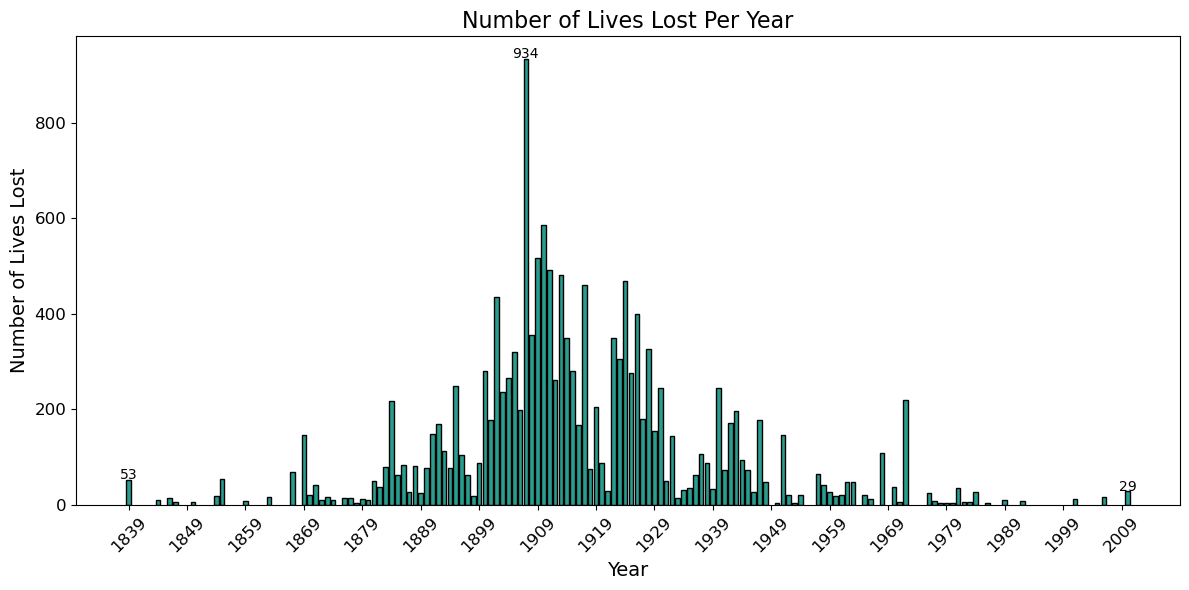

In [9]:
#Plot Fatality graph

# Ensure the 'Date' column is parsed for the 'Year'
cleaned_data_coord1['Year'] = pd.to_datetime(cleaned_data_coord1['Date'], errors='coerce').dt.year

# Group data by year and calculate total fatalities
yearly_data = cleaned_data_coord1.groupby('Year', as_index=False)['Killed'].sum()

# Plot the number of killed for each year
plt.figure(figsize=(12, 6))
plt.bar(yearly_data['Year'], yearly_data['Killed'], color="#2a9d8f", edgecolor="black")

# Add labels and title
plt.title("Number of Lives Lost Per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Lives Lost", fontsize=14)

# Adjust x-ticks to show every 10 years
plt.xticks(
    ticks=range(int(yearly_data['Year'].min()), int(yearly_data['Year'].max()) + 1, 10),
    fontsize=12,
    rotation=45
)
plt.yticks(fontsize=12)

# Add numbers only at the first, last, and 1907
for _, row in yearly_data.iterrows():
    if row['Year'] == yearly_data['Year'].min() or row['Year'] == yearly_data['Year'].max() or row['Year'] == 1907:
        plt.text(row['Year'], row['Killed'] + 1, str(row['Killed']), ha='center', fontsize=10, color='black')

# Show the plot without grid lines
plt.tight_layout()
plt.show()


Put bubbles showing years when safety regulations are added to see if that affected the reduced number of fatalies from early 1900s

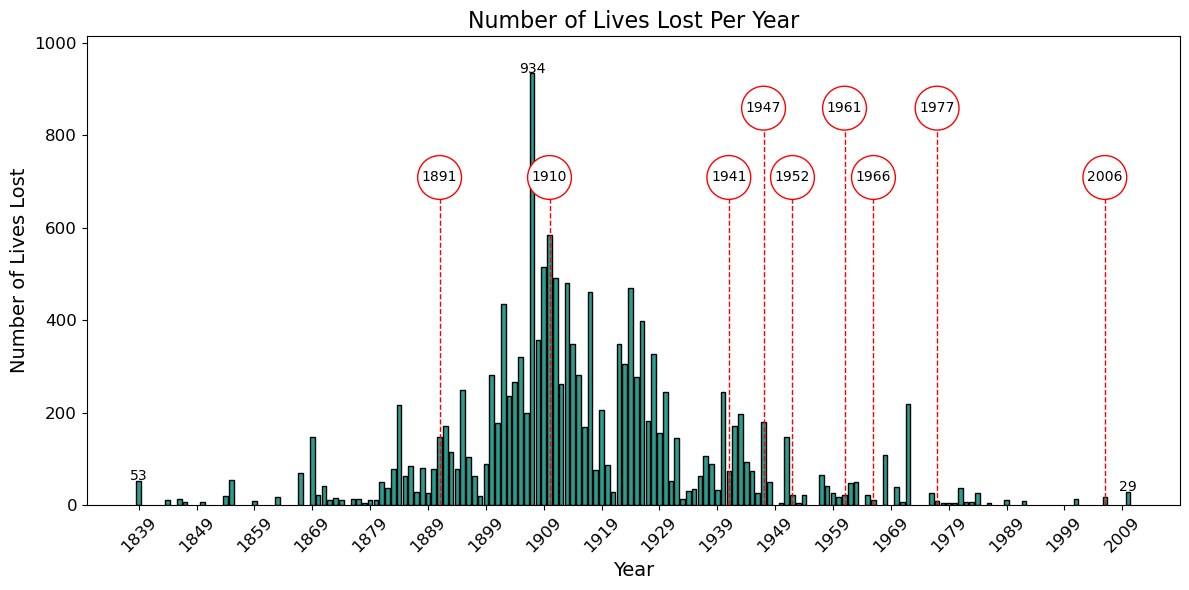

In [10]:
# Convert the 'Date' column to datetime format and extract the year
cleaned_data_coord1['Year'] = pd.to_datetime(cleaned_data_coord1['Date'], errors='coerce').dt.year

# Group data by year and calculate total fatalities
yearly_data = cleaned_data_coord1.groupby('Year', as_index=False)['Killed'].sum()

# Define years of regulations and their adjusted heights
regulation_years = [1891, 1910, 1941, 1947, 1952, 1961, 1966, 1969, 1973, 1977, 2006]
bubble_heights = {  # Adjust heights for specific years
    1891: 700,
    1910: 700,
    1941: 700,
    1947: 850,
    1952: 700,
    1961: 850,
    1966: 700,
    1969: 850,
    1973: 700,
    1977: 850,
    2006: 700
}

# Plot the number of killed for each year
plt.figure(figsize=(12, 6))
plt.bar(yearly_data['Year'], yearly_data['Killed'], color="#2a9d8f", edgecolor="black")

# Add labels and title
plt.title("Number of Lives Lost Per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Lives Lost", fontsize=14)

# Set x-ticks to show every 10 years
plt.xticks(
    ticks=range(int(yearly_data['Year'].min()), int(yearly_data['Year'].max()) + 1, 10),
    fontsize=12,
    rotation=45
)
plt.yticks(fontsize=12)

# Add dotted marks for regulation years with adjusted bubble heights
for reg_year in regulation_years:
    if reg_year in yearly_data['Year'].values:
        bubble_height = bubble_heights[reg_year]
        # Dotted line only goes to the bubble
        plt.axvline(x=reg_year, color='red', linestyle='--', linewidth=1, ymax=bubble_height / (yearly_data['Killed'].max() + 80))
        # Add the bubble with the year
        plt.text(reg_year, bubble_height, str(reg_year), ha='center', fontsize=10,
                 bbox=dict(boxstyle="circle,pad=0.3", edgecolor="red", facecolor="white"))

# Add numbers only at the first, last, and 1907
for index, row in yearly_data.iterrows():
    if row['Year'] == yearly_data['Year'].min() or row['Year'] == yearly_data['Year'].max() or row['Year'] == 1907:
        plt.text(row['Year'], row['Killed'] + 1, str(row['Killed']), ha='center', fontsize=10)

# Adjust plot limits to ensure space for all bubbles
plt.ylim(0, yearly_data['Killed'].max() + 80)

# Show the plot
plt.tight_layout()
plt.show()


Plot a graph that shows fatalities for each state, and show the mining sector corresponding to it

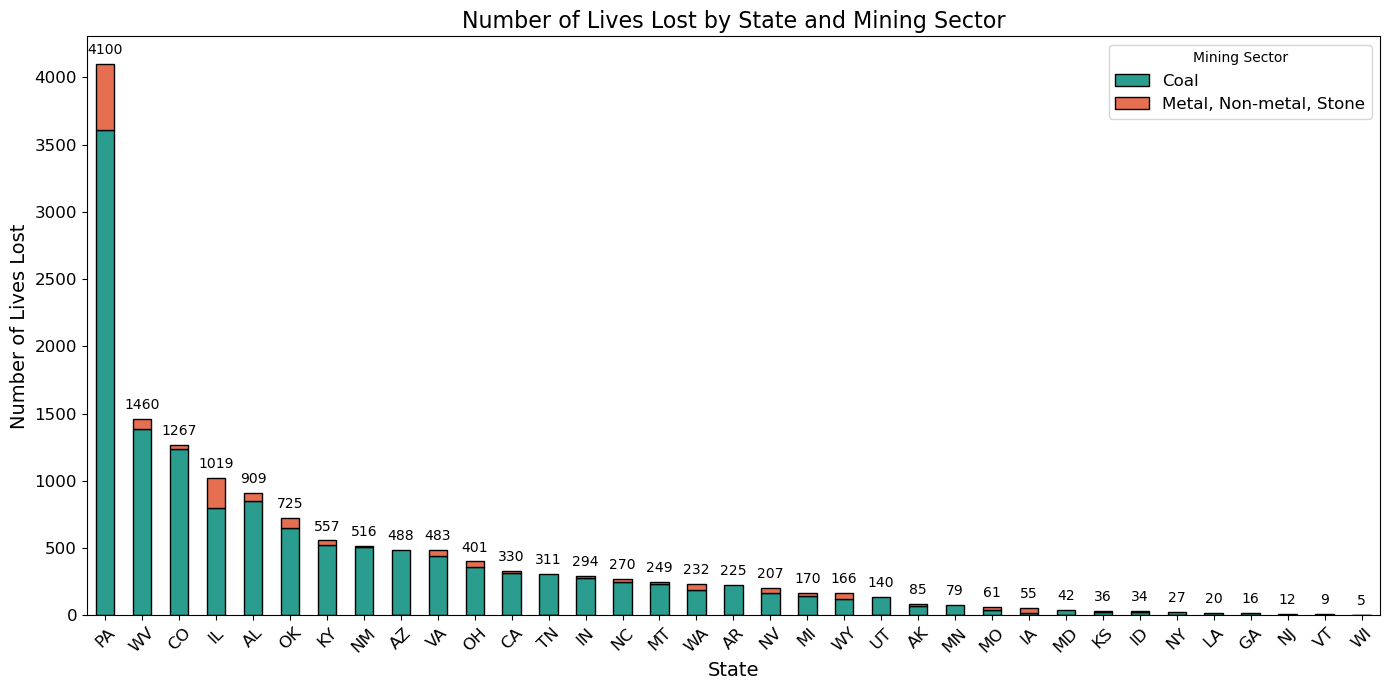

In [11]:
# Group data by State and Mining Sector, calculate total fatalities
cleaned_data_coord1['Mining Sector'] = cleaned_data_coord1['Mining Sector'].apply(lambda x: 'Coal' if x.lower() == 'coal' else 'Metal, Non-metal, Stone')
state_sector_data = cleaned_data_coord1.groupby(['State_Abbr', 'Mining Sector'], as_index=False)['Killed'].sum()

# Pivot for better visualization in the bar graph
state_sector_pivot = state_sector_data.pivot(index='State_Abbr', columns='Mining Sector', values='Killed').fillna(0)

# Sort the states by total fatalities (highest to smallest)
state_sector_pivot['Total'] = state_sector_pivot.sum(axis=1)
state_sector_pivot = state_sector_pivot.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plotting the data
ax = state_sector_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), color=["#2a9d8f", "#e76f51"], edgecolor="black")

# Add labels and title
plt.title("Number of Lives Lost by State and Mining Sector", fontsize=16)
plt.xlabel("State", fontsize=14)
plt.ylabel("Number of Lives Lost", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Mining Sector", fontsize=12)

# Add total number on top of each stacked bar
for index, row in state_sector_pivot.iterrows():
    total = row.sum()
    x = list(state_sector_pivot.index).index(index)  # Get the x-coordinate for the bar
    ax.annotate(f'{int(total)}',
                (x, total),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
# Display the plot
plt.show()


This tells me that Pensilvania, West Verginia, and Colorado are top 3 states with greatest fatalities. It also tells fatalies happened mainly in coal mine. Let's investigate the most frequent accident type of coal mine.

In [14]:
# Filter the data for "Coal" mining sector
coal_data = cleaned_data_coord1[cleaned_data_coord1['Mining Sector'].str.lower() == 'coal']

# Count the occurrences of each 'Accident Type' for coal mining
coal_accident_counts = coal_data['Accident Type'].value_counts()

# Convert the Series to a DataFrame
coal_accident_counts_df = coal_accident_counts.reset_index()

# Rename the columns for clarity
coal_accident_counts_df.columns = ['Accident Type', 'Count']

# Display the DataFrame
coal_accident_counts_df

,Accident Type,Count
0,Explosion,478
1,Fire,48
2,Haulage,21
3,Roof fall/bump,9
4,Inrush of water,6
5,Suffocation,4
6,Roof fall,4
7,Inundation,4
8,Explosives,4
9,Suffocated by gas,3


In [15]:
# Calculate the total number of accidents
total_accidents = coal_data['Accident Type'].value_counts().sum()

# Calculate the number of "Explosion" accidents
explosion_accidents = coal_data['Accident Type'].str.contains("Explosion", case=False, na=False).sum()

# Calculate the percentage of "Explosion" accidents
explosion_percentage = (explosion_accidents / total_accidents) * 100

# Display the result
print(f"Percentage of 'Explosion' accidents: {explosion_percentage:.2f}%")


Percentage of 'Explosion' accidents: 80.00%


In order to see how improvement of technology played a role of deduction of number of fatalities, plot the years when mining technology was improved.

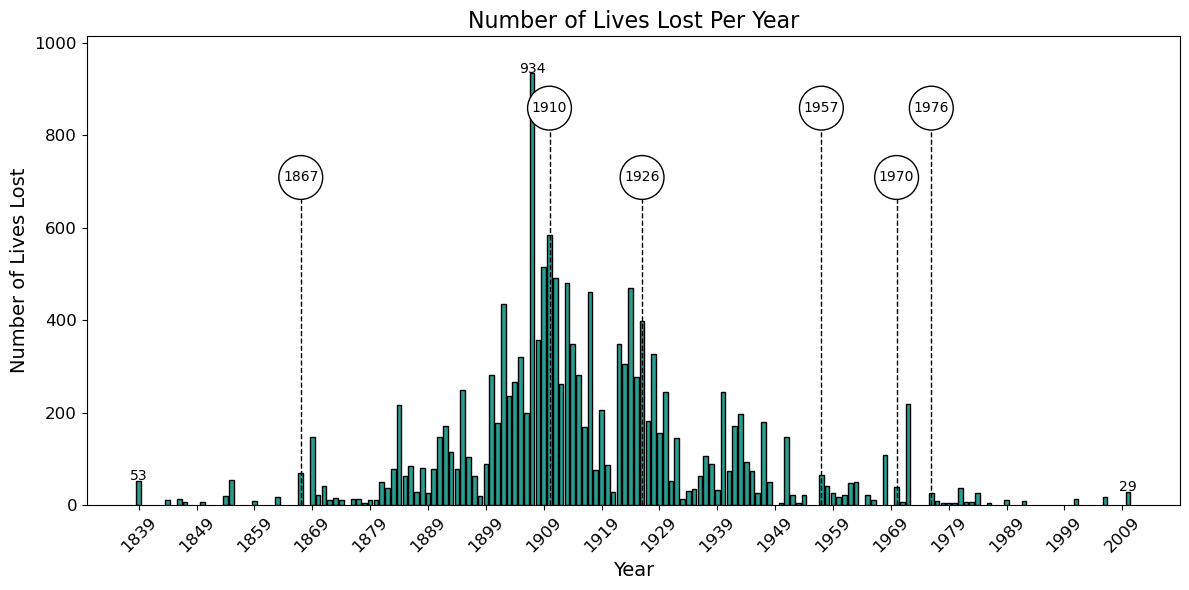

In [12]:
# Convert the 'Date' column to datetime format and extract the year
cleaned_data_coord1['Year'] = pd.to_datetime(cleaned_data_coord1['Date'], errors='coerce').dt.year

# Group data by year and calculate total fatalities
yearly_data = cleaned_data_coord1.groupby('Year', as_index=False)['Killed'].sum()

# Define years of technological advancements and their adjusted heights
advancement_years = [1867, 1910, 1926, 1957, 1970, 1976, 1993]
bubble_heights = {  # Adjust heights for specific years
    1867: 700,
    1910: 850,
    1926: 700,
    1957: 850,
    1970: 700,
    1976: 850,
    1993: 700
}

# Plot the number of killed for each year
plt.figure(figsize=(12, 6))
plt.bar(yearly_data['Year'], yearly_data['Killed'], color="#2a9d8f", edgecolor="black")

# Add labels and title
plt.title("Number of Lives Lost Per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Lives Lost", fontsize=14)

# Set x-ticks to show every 10 years
plt.xticks(
    ticks=range(int(yearly_data['Year'].min()), int(yearly_data['Year'].max()) + 1, 10),
    fontsize=12,
    rotation=45
)
plt.yticks(fontsize=12)

# Add dotted marks for advancement years with adjusted bubble heights
for adv_year in advancement_years:
    if adv_year in yearly_data['Year'].values:
        bubble_height = bubble_heights[adv_year]
        # Dotted line only goes to the bubble
        plt.axvline(x=adv_year, color='black', linestyle='--', linewidth=1, ymax=bubble_height / (yearly_data['Killed'].max() + 80))
        # Add the bubble with the year
        plt.text(adv_year, bubble_height, str(adv_year), ha='center', fontsize=10,
                 bbox=dict(boxstyle="circle,pad=0.3", edgecolor="black", facecolor="white"))

# Add numbers only at the first, last, and 1907
for index, row in yearly_data.iterrows():
    if row['Year'] == yearly_data['Year'].min() or row['Year'] == yearly_data['Year'].max() or row['Year'] == 1907:
        plt.text(row['Year'], row['Killed'] + 1, str(row['Killed']), ha='center', fontsize=10)

# Adjust plot limits to ensure space for all bubbles
plt.ylim(0, yearly_data['Killed'].max() + 80)

# Show the plot
plt.tight_layout()
plt.show()
